<a href="https://colab.research.google.com/github/zahra-sharifzadeh/pytorch/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

2.0.0+cu118


## 1. What are 3 areas in industry where computer vision is currently being used?

1. self driving cars like tesla
2. healthcare industry ( like diagnosing diseases)
3. security (face recog, biometric features)

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

learning so much not useful detail like noise that prevent the model to be generalize on unseen data

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. more training data and Data augmentation
2. resampling data
3. use regulation for model 
4. evalution dataset
5. drop out in neural network and Ensembling
6. Early stopping
7. Pruning or feature selection
8.Use a different model (like transfer learning)

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
    target_transform=None

)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

In [5]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [7]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
img , label = train_data[0]
img.shape , label

(torch.Size([1, 28, 28]), 5)

In [9]:
class_names[5]

'5 - five'

## 6. Visualize at least 5 different samples of the MNIST training dataset.

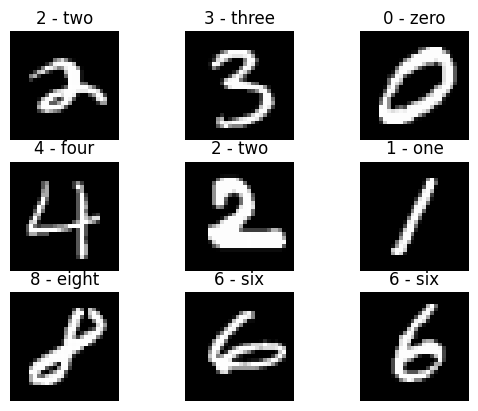

In [10]:
nrows , ncols = 3, 3
for i in range(1, nrows * ncols + 1):
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  img , label = train_data[random_idx]
  img_squeezed = img.squeeze()
  plt.subplot(nrows, ncols, i)
  plt.imshow(img_squeezed, cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7ace9740d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7ace9491c0>)

In [12]:
print(f"Length of Train_dataloader is {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"length of test_dataloader is {len(test_dataloader)} batches of {BATCH_SIZE}...")

Length of Train_dataloader is 1875 batches of 32...
length of test_dataloader is 313 batches of 32...


In [13]:
# Check out what 's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [14]:
# Check out what 's inside the testing dataloader
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [15]:
from torch.nn.modules.pooling import MaxPool2d
class MnistModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(#Start conv block 2
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1),

        nn.ReLU(),
        
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        
        )#End conv block 2
    

    self.conv_block_2 = nn.Sequential(#Start conv block 2
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.ReLU(), 

        nn.MaxPool2d(kernel_size=2, 
                     stride=2)  
    )#End conv block 2

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7, 
                  out_features=10)
    )

  def forward(self, x):
    z = self.conv_block_1(x)
    #print("conv block1 shape:", z.shape)

    z = self.conv_block_2(z)
    #print("conv block2 shape:", z.shape)

    z = self.classifier(z)
    #print("classifier shape:", z.shape)

    return z 


dummy_input = torch.randn(size=(1,1,28,28)).to(device)

model_2 = MnistModelV2(input_shape=1,
                       hidden_units=10,
                       output_shape=10).to(device)
model_2(dummy_input)



tensor([[-0.0502,  0.0488, -0.0017,  0.0468, -0.0108,  0.0400, -0.0036, -0.0412,
         -0.0229, -0.0064]], grad_fn=<AddmmBackward0>)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [16]:
import requests
from pathlib import Path

In [17]:
if Path("helper_functions.py").is_file():
  print("helper_function.py is already exist!! skipping download.;)")

else:
  print("Downloading helper_function.py ....")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_function.py is already exist!! skipping download.;)


In [18]:
from helper_functions import accuracy_fn

In [19]:
from timeit import default_timer as timer


In [20]:
def train_step(model : torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim,
    accuracy_fn,
    device: torch.device = device):
  
  model.to(device)
  model.train()

  train_loss = 0 
  train_acc = 0

  for  batche, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

  # 1. Forward_pass
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=0).argmax(dim=1)

  # 2. caculate loss and accuracy
    loss = loss_fn(y_logit, y)
    train_loss += loss


    acc = accuracy_fn(y, y_pred)
    train_acc += acc

  # 3. optimizer zero grad
    optimizer.zero_grad()

  # 4. backpropagation
    loss.backward()

  #5. optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader) 

  # print what 's happened

  print(f"Train loss: {train_loss:.5f} | Train ACC: {train_acc:.2f}%\n")



In [21]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
  
  model.to(device)
  model.eval()
  test_loss = 0
  test_acc = 0

  
  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      y_logit = model(X)
      y_pred = torch.softmax(y_logit, dim=0).argmax(dim=1)

      loss = loss_fn(y_logit, y)
      test_loss += loss

      acc = accuracy_fn(y_true=y, y_pred=y_pred)
      test_acc += acc

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} | Test ACC: {test_acc:.2f}%\n")  

  




In [22]:
#########################################################################################################

In [23]:
#CPU

#set up epoch
from tqdm.auto import tqdm


torch.manual_seed(42)

model_cpu = MnistModelV2(input_shape=1,
                         hidden_units=10,
                         output_shape=10)

start_time_cpu = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}......")

  train_step(model_cpu,
               data_loader=train_dataloader,
               loss_fn = loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device= device)
  test_step(model_cpu,
               data_loader=test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn=accuracy_fn,
               device= device)
  

end_time_cpu = timer()

total_cpu_time = end_time_cpu - start_time_cpu

print(f"cpu time for training model is {total_cpu_time}.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0......
Train loss: 0.26560 | Train ACC: 81.73%

Test loss: 0.07672 | Test ACC: 90.51%

Epoch:1......
Train loss: 0.06840 | Train ACC: 87.81%

Test loss: 0.04390 | Test ACC: 92.47%

Epoch:2......
Train loss: 0.05379 | Train ACC: 88.77%

Test loss: 0.04583 | Test ACC: 93.07%

Epoch:3......
Train loss: 0.04419 | Train ACC: 89.15%

Test loss: 0.04233 | Test ACC: 92.26%

Epoch:4......
Train loss: 0.03947 | Train ACC: 89.35%

Test loss: 0.03516 | Test ACC: 92.90%

cpu time for training model is 272.176039968.


In [24]:
cpu_train_time = 297.705991195
cpu_train_time

297.705991195

In [25]:
# GPU
#set up epoch
from tqdm.auto import tqdm


torch.manual_seed(42)

model_gpu = MnistModelV2(input_shape=1,
                         hidden_units=10,
                         output_shape=10)

start_time_gpu = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch:{epoch}......")

  train_step(model_gpu,
               data_loader=train_dataloader,
               loss_fn = loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device= device)
  test_step(model_gpu,
               data_loader=test_dataloader,
               loss_fn = loss_fn,
               accuracy_fn=accuracy_fn,
               device= device)
  

end_time_gpu = timer()

total_gpu_time = end_time_gpu - start_time_gpu

print(f"gpu time for training model is {total_gpu_time}.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0......
Train loss: 0.26560 | Train ACC: 81.73%

Test loss: 0.07672 | Test ACC: 90.51%

Epoch:1......
Train loss: 0.06840 | Train ACC: 87.81%

Test loss: 0.04390 | Test ACC: 92.47%

Epoch:2......
Train loss: 0.05379 | Train ACC: 88.77%

Test loss: 0.04583 | Test ACC: 93.07%

Epoch:3......
Train loss: 0.04419 | Train ACC: 89.15%

Test loss: 0.04233 | Test ACC: 92.26%

Epoch:4......
Train loss: 0.03947 | Train ACC: 89.35%

Test loss: 0.03516 | Test ACC: 92.90%

gpu time for training model is 262.738483905.


In [26]:
gpu_train_time = 74.2662855930000
gpu_train_time

74.266285593

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [27]:
def make_predictions(
    model: nn.Module,
    data: list,
    device: torch.device =device):
  
  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample,dim=0).to(device)

      y_logit = model(sample)
      y_prob = torch.softmax(y_logit.squeeze(), dim=0)


      pred_probs.append(y_prob.cpu())

  
  return torch.stack(pred_probs)


In [28]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [29]:
import random

test_samples = []
test_labels = []

for sample , label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape , test_labels[0]


(torch.Size([1, 28, 28]), 9)

In [30]:
y_prob = make_predictions(model=model_cpu,
                          data = test_samples,
                          device=device)
y_pred = y_prob.argmax(dim=1)
y_pred


tensor([9, 3, 6, 4, 2, 5, 1, 7, 9])

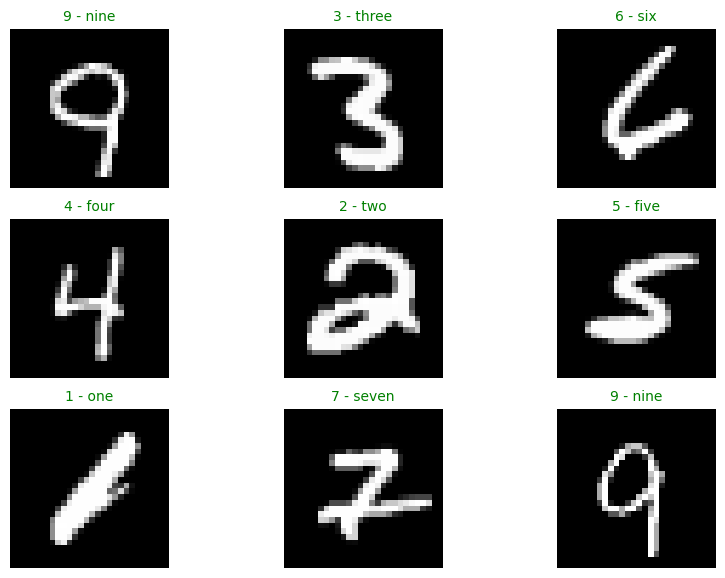

In [31]:
nrows, ncols = 3,3
plt.figure(figsize=(10,7))
for i in range(0, nrows * ncols):

  plt.subplot(nrows, ncols, i+1)
  plt.imshow(test_samples[i].squeeze(), cmap="gray")
  plt.axis(False)

  if test_labels[i] == y_pred[i].item():
    plt.title(class_names[test_labels[i]], fontsize=10, color="green")

  else: 
    s = f"Truth label:{class_names[test_labels[i]]}| pred label:{class_names[y_pred[i]]}"
    plt.title(s, fontsize=10, color="red")



## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [32]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [33]:
from tqdm.auto import tqdm
y_true = []
y_preds = []
model_cpu.eval()
with torch.inference_mode():
  for batch , (X, y) in tqdm(enumerate(test_dataloader)):
    # print(X.shape)
    X, y = X.to(device), y.to(device)
    y_logit = model_cpu(X)
    y_true.append(y.cpu())
    # loss = loss_fn(y_logit, y)
    # print(loss)
    # print(y_logit.shape)
    y_prob =  y_logit.softmax(dim=1)

    y_pred = y_prob.argmax(dim=1)
    # print(accuracy_fn(y, y_pred))

    y_preds.append(y_pred.cpu())

  y_preds = torch.cat(y_preds)
  y_true = torch.cat(y_true)
  

 


0it [00:00, ?it/s]

In [34]:

y_true[:10], y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

In [35]:
try:
  import torchmetrics, mlxtend
  print(f"mixtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19 or higher"

except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics , mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version: 0.22.0


In [36]:
test_data.targets.shape

torch.Size([10000])

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, target=test_data.targets)

confmat_tensor

tensor([[ 977,    0,    0,    0,    0,    0,    0,    1,    2,    0],
        [   0, 1122,    4,    1,    3,    0,    0,    1,    4,    0],
        [   2,    0, 1021,    1,    2,    0,    0,    3,    3,    0],
        [   0,    0,    1, 1004,    0,    2,    0,    1,    2,    0],
        [   1,    0,    1,    0,  972,    0,    0,    1,    2,    5],
        [   1,    0,    0,    8,    0,  880,    1,    1,    0,    1],
        [   7,    2,    0,    0,    3,    4,  939,    0,    3,    0],
        [   0,    4,    6,    2,    1,    0,    0, 1012,    1,    2],
        [   1,    0,    1,    0,    0,    2,    0,    0,  967,    3],
        [   2,    1,    0,    0,    6,    4,    1,    6,    5,  984]])

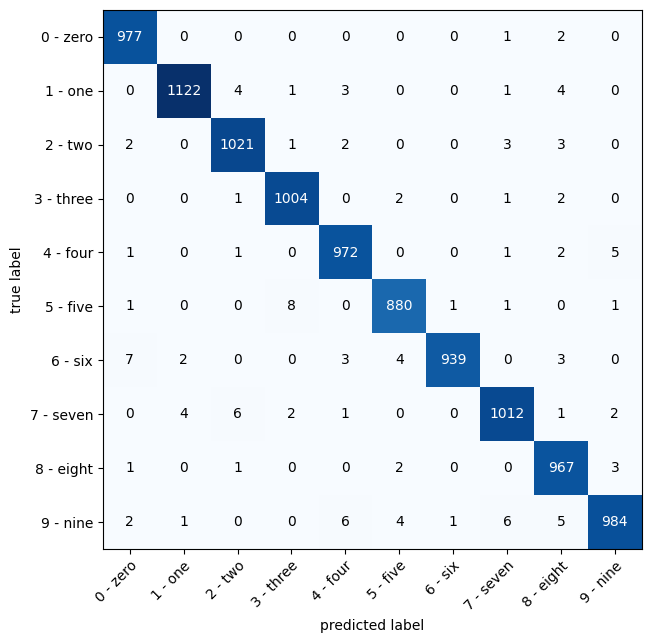

In [38]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [39]:
dummy_input = torch.randn(size=(1, 3, 64, 64))
print(dummy_input.shape)
conv_model_1 = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=6,
                       stride=1,
                       padding=1)
conv_model_2 = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=1,
                       stride=1,
                       padding=1)

torch.Size([1, 3, 64, 64])


In [40]:
conv_model_1(dummy_input).shape

torch.Size([1, 10, 61, 61])

In [41]:
conv_model_2(dummy_input).shape

torch.Size([1, 10, 66, 66])

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [42]:
trian_data_FashionMNIST = datasets.FashionMNIST(
    root="Fashion",
    download=True,
    transform=ToTensor(),
    target_transform=None,
    train = True
)

test_data_FashionMNIST = datasets.FashionMNIST(
    root="Fashion",
    download=True,
    transform=ToTensor(),
    target_transform=None,
    train = False
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11109730.71it/s]


Extracting Fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to Fashion/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200096.79it/s]


Extracting Fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Fashion/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3725248.57it/s]


Extracting Fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Fashion/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10548254.51it/s]

Extracting Fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Fashion/FashionMNIST/raw



In [43]:
BATCH_SIZE = 32
train_fashion_dataloader = torch.utils.data.DataLoader(
    dataset=trian_data_FashionMNIST,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_fashion_dataloader = torch.utils.data.DataLoader(
    dataset=test_data_FashionMNIST,
    batch_size = BATCH_SIZE,
    shuffle = False)

In [44]:
fashion_classes = trian_data_FashionMNIST.classes
fashion_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [45]:
model_fashion = MnistModelV2(input_shape=1,
                             hidden_units=10,
                             output_shape=10)

In [46]:
model_fashion

MnistModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_fashion.parameters(),
                            lr=0.1)

In [48]:
torch.manual_seed(42)

epochs = 5
for epoch in tqdm(range(epochs)):

  train_step(model=model_fashion,
            data_loader=train_fashion_dataloader,
              optimizer= optimizer,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  test_step(model=model_fashion,
            data_loader=test_fashion_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)



  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.60186 | Train ACC: 72.26%

Test loss: 0.38612 | Test ACC: 78.16%

Train loss: 0.35541 | Train ACC: 78.95%

Test loss: 0.34406 | Test ACC: 80.08%

Train loss: 0.32046 | Train ACC: 79.95%

Test loss: 0.31510 | Test ACC: 80.09%

Train loss: 0.30180 | Train ACC: 80.06%

Test loss: 0.30814 | Test ACC: 79.88%

Train loss: 0.28766 | Train ACC: 80.81%

Test loss: 0.30106 | Test ACC: 80.14%



In [49]:
model_fashion.eval()
model_fashion.to(device)

y_preds = []
y_true = []
for X, y in test_fashion_dataloader:
  X, y = X.to(device), y.to(device)
  y_true.append(y.cpu())
  y_logit = model_fashion(X)
  y_prob = y_logit.softmax(dim=1)
  y_pred = y_prob.argmax(dim=1)

  y_preds.append(y_pred.cpu())
y_true = torch.cat(y_true)
y_preds = torch.cat(y_preds)
  # print(y_logit.shape)
print(y_preds) 
print(y_true)


tensor([9, 2, 1,  ..., 8, 1, 5])
tensor([9, 2, 1,  ..., 8, 1, 5])


In [50]:
test_data_FashionMNIST.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [51]:
len(y_true)

10000

In [52]:
wrong_idx = []
for i in range(len(y_true)):
  if test_data_FashionMNIST.targets[i] != y_preds[i]:
    wrong_idx.append(i)

len(wrong_idx)

1073

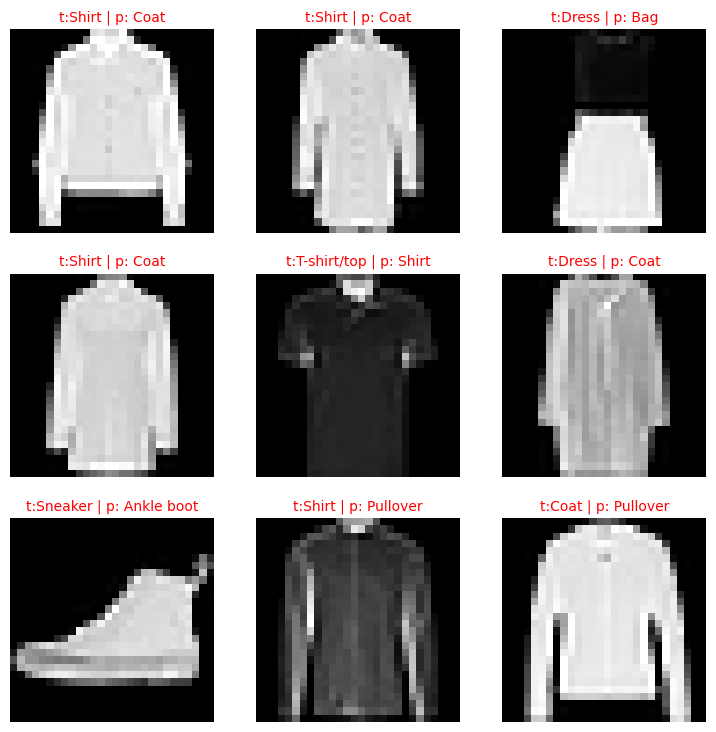

In [78]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
samples = random.sample(wrong_idx,k=9)
i=0
for sample in samples:
  i= i+1
  img , label = test_data_FashionMNIST[sample]
  plt.subplot(rows, cols,i)
  plt.imshow(img.squeeze(dim=0), cmap="gray")
  s= f"t:{fashion_classes[label]} | p: {fashion_classes[y_preds[sample]]}"
  plt.title(s , fontsize=10, color="red")
  plt.axis(False)
  
